In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import warnings
warnings.filterwarnings("ignore")

What is glob?



glob is a Python standard library module used to search for files and directories whose names match a specific pattern.



It’s like a file-search tool: instead of typing every filename manually, you can use patterns like *.csv or *.txt to automatically collect matching files.

In [2]:
FIG_SIZE = (8,6)

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
path = "/content/drive/My Drive/files/*.csv"
l = [pd.read_csv(filename) for filename in glob.glob(path)]
print(len(l))
df = pd.concat(l,axis=0)
df.head()


50


,sale_time,purchaser_gender
0,2013-01-21 00:37:35,female
1,2013-01-21 01:26:47,female
2,2013-01-21 01:30:29,female
3,2013-01-21 01:59:18,female
4,2013-01-21 02:13:22,male


## Question 1
Plot daily sales for all 50 weeks.

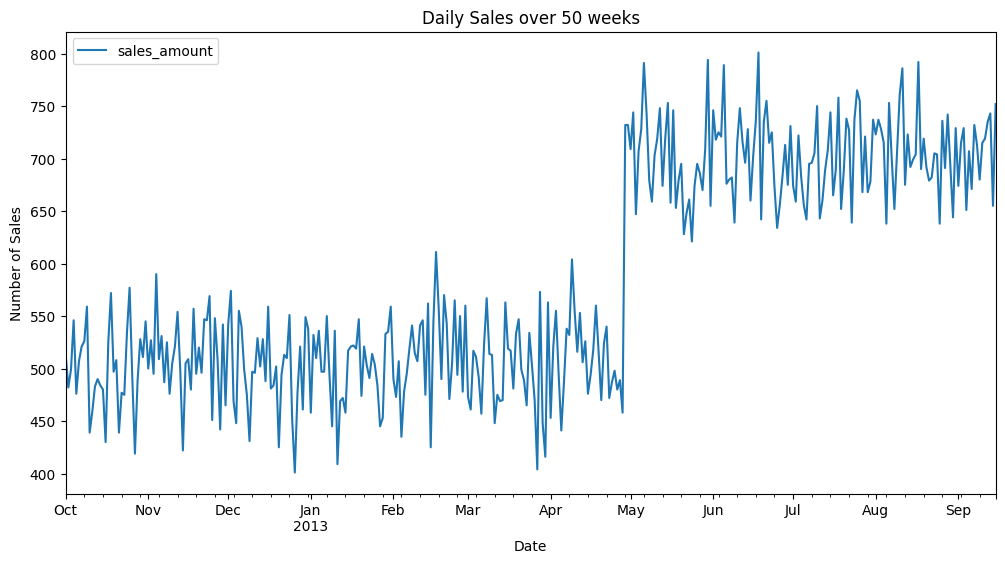

In [17]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'sale_day' is your datetime Series (e.g., df['sale_time'])
# Step 1: Convert to datetime if not already
sale_day = pd.to_datetime(sale_day)

# Step 2: Aggregate daily sales
daily_sales_df = sale_day.groupby(sale_day.dt.floor('d')).size().reset_index(name='sales_amount')

# Step 3: Rename the first column to 'sale_day' (robust way)
first_col_name = daily_sales_df.columns[0]
daily_sales_df.rename(columns={first_col_name: 'sale_day'}, inplace=True)

# Step 4: Set 'sale_day' as the index
daily_sales_df.set_index('sale_day', inplace=True)

# Step 5: Plot daily sales
FIG_SIZE = (12,6)  # Example figure size
ax = daily_sales_df.plot(figsize=FIG_SIZE)
ax.set_title("Daily Sales over 50 weeks")
ax.set_xlabel("Date")
ax.set_ylabel("Number of Sales")
plt.show()


## Question 2
It looks like there has been a sudden change in daily sales. What date did it occur?

In [18]:
# compare sales amount difference with the previous day and find the biggest difference
# which should give the sudden change in the plot
daily_sales_df['prev_day_sale_amount'] = [None] + daily_sales_df['sales_amount'].to_list()[:-1]
daily_sales_df['difference_btw_prev_day'] = daily_sales_df['sales_amount'] - daily_sales_df['prev_day_sale_amount']
daily_sales_df.head()

,sales_amount,prev_day_sale_amount,difference_btw_prev_day
sale_day,,,
2012-10-01,514,NaN,NaN
2012-10-02,482,514.0,-32.0
2012-10-03,499,482.0,17.0
2012-10-04,546,499.0,47.0
2012-10-05,476,546.0,-70.0


.idxmax() → returns the index of the maximum value in the Series.

In [19]:
# get the index of max change to answer what date did it occur
max_change_date = daily_sales_df['difference_btw_prev_day'].idxmax()
daily_sales_df.loc[[max_change_date]]

,sales_amount,prev_day_sale_amount,difference_btw_prev_day
sale_day,,,
2013-04-29,732,458.0,274.0


## Question 3
Is the change in daily sales at the date you selected statistically significant? If so, what is the p-value?

In [20]:
from scipy import stats

# Define the date at which the largest change in daily sales was observed
change_date = '2013-04-29'

# Split the dataset into two groups: one before the change date and one after (inclusive)
# Since the DataFrame index contains datetime values, direct comparison is valid
before = daily_sales_df[daily_sales_df.index < change_date]['sales_amount']
after = daily_sales_df[daily_sales_df.index >= change_date]['sales_amount']

# Perform a two-sample Welch’s t-test to evaluate whether the difference
# in average daily sales between the two periods is statistically significant.
# We assume unequal variance between the two groups by setting equal_var=False
t_stat, p_value = stats.ttest_ind(before, after, equal_var=False)

print("t-statistic:", t_stat)
print("p-value:", p_value)

t-statistic: -45.943533193935615
p-value: 3.487246853115062e-138


## Question 4
Does the data suggest that the change in daily sales is due to a shift in the proportion of male-vs-female customers? Please use plots to support your answer (a rigorous statistical analysis is not necessary).

In [21]:
# create gender_portions_df to analyze sales distribution over genders
df['sale_day'] = pd.to_datetime(df['sale_time']).dt.floor('d')
gender_portions_df = df.groupby(['sale_day', 'purchaser_gender']).size().reset_index(name='sales_amount')

In [22]:
gender_portions_df

,sale_day,purchaser_gender,sales_amount
0,2012-10-01,female,413
1,2012-10-01,male,101
2,2012-10-02,female,379
3,2012-10-02,male,103
4,2012-10-03,female,386
...,...,...,...
695,2013-09-13,male,537
696,2013-09-14,female,193
697,2013-09-14,male,462
698,2013-09-15,female,230


In [23]:
# calculate female and male sales amount separately
new_df = pd.DataFrame(gender_portions_df['sale_day'].unique(),columns=['sale_day'])
new_df['female_sales_amount'] = pd.Series(gender_portions_df[gender_portions_df.purchaser_gender == 'female']['sales_amount']).reset_index(drop=True)
new_df['male_sales_amount'] = pd.Series(gender_portions_df[gender_portions_df.purchaser_gender == 'male']['sales_amount']).reset_index(drop=True)
new_df[-5:]

,sale_day,female_sales_amount,male_sales_amount
345,2013-09-11,224,495
346,2013-09-12,225,510
347,2013-09-13,206,537
348,2013-09-14,193,462
349,2013-09-15,230,522


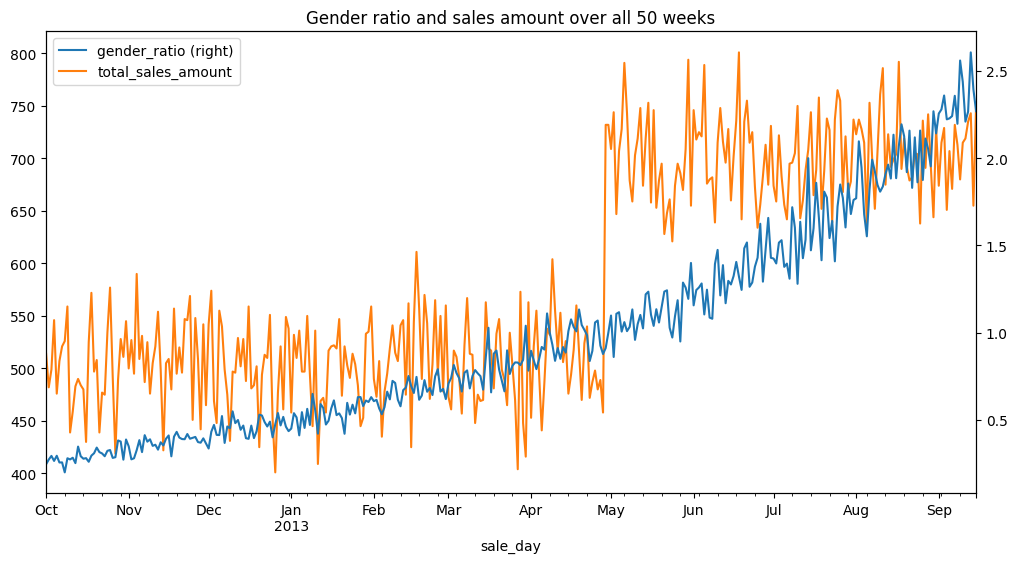

In [24]:
# calculate gender ratio of sales
new_df['gender_ratio'] = new_df['male_sales_amount']/new_df['female_sales_amount']

# plot gender ratio change over 50 weeks with the total sales amount
# observe if there is a correlation between them
plot_df = new_df.copy()
plot_df['total_sales_amount']  = plot_df['male_sales_amount'] + plot_df['female_sales_amount']
plot_df.drop(columns=['female_sales_amount', 'male_sales_amount'], inplace=True)
plot_df.index = plot_df['sale_day']
plot_df.drop(columns=['sale_day'], inplace=True)
plot_df.plot(secondary_y = ['gender_ratio'],figsize=FIG_SIZE, title= "Gender ratio and sales amount over all 50 weeks")
plt.show()

## Question 5
Assume a given day is divided into four dayparts: night (12:00AM - 6:00AM), morning (6:00AM to 12:00PM), afternoon (12:00PM to 6:00PM) and evening (6:00PM - 12:00AM). What is the percentage of sales in each daypart over all 50 weeks?

In [25]:
# extract sale hour to divide sales to the part of days
df['sale_hour']  = pd.to_datetime(df['sale_time']).dt.ceil('h').dt.hour
df.dtypes

,0
sale_time,object
purchaser_gender,object
sale_day,datetime64[ns]
sale_hour,int32


In [26]:
# define a function to apply sale hour column to decide a part of day based on the mentioned logic
def assign_day_part(sale_hour):
    """Assign labels based on sale hour."""
    if sale_hour >= 6 and sale_hour < 12:
        return 'morning'
    if sale_hour >= 12 and sale_hour < 18:
        return 'afternoon'
    if sale_hour >= 18 and sale_hour < 24:
        return 'evening'
    if sale_hour >= 0 and sale_hour < 6:
        return 'night'

In [27]:
# apply the defined function and create day_part column
df['day_part'] = df['sale_hour'].apply(assign_day_part)

# drop unnecessary columns
df.drop(columns = ['purchaser_gender', 'sale_hour', 'sale_time'], inplace= True)

In [28]:
# calculate sales amount per day part
df_pct_sales = df.groupby(df.day_part).size().reset_index(name='day_part_sales_amount')

# calculate sales amount percentage per day part
df_pct_sales['day_part_sales_percentage'] = df_pct_sales['day_part_sales_amount'] / df_pct_sales['day_part_sales_amount'].sum()

In [29]:
df_pct_sales

,day_part,day_part_sales_amount,day_part_sales_percentage
0,afternoon,81159,0.397198
1,evening,53523,0.261945
2,morning,56080,0.274459
3,night,13567,0.066398
